In [7]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches # For bounding boxes

from PIL import Image

from collections import defaultdict
import json

plt.rcParams['figure.figsize'] = (15, 15)

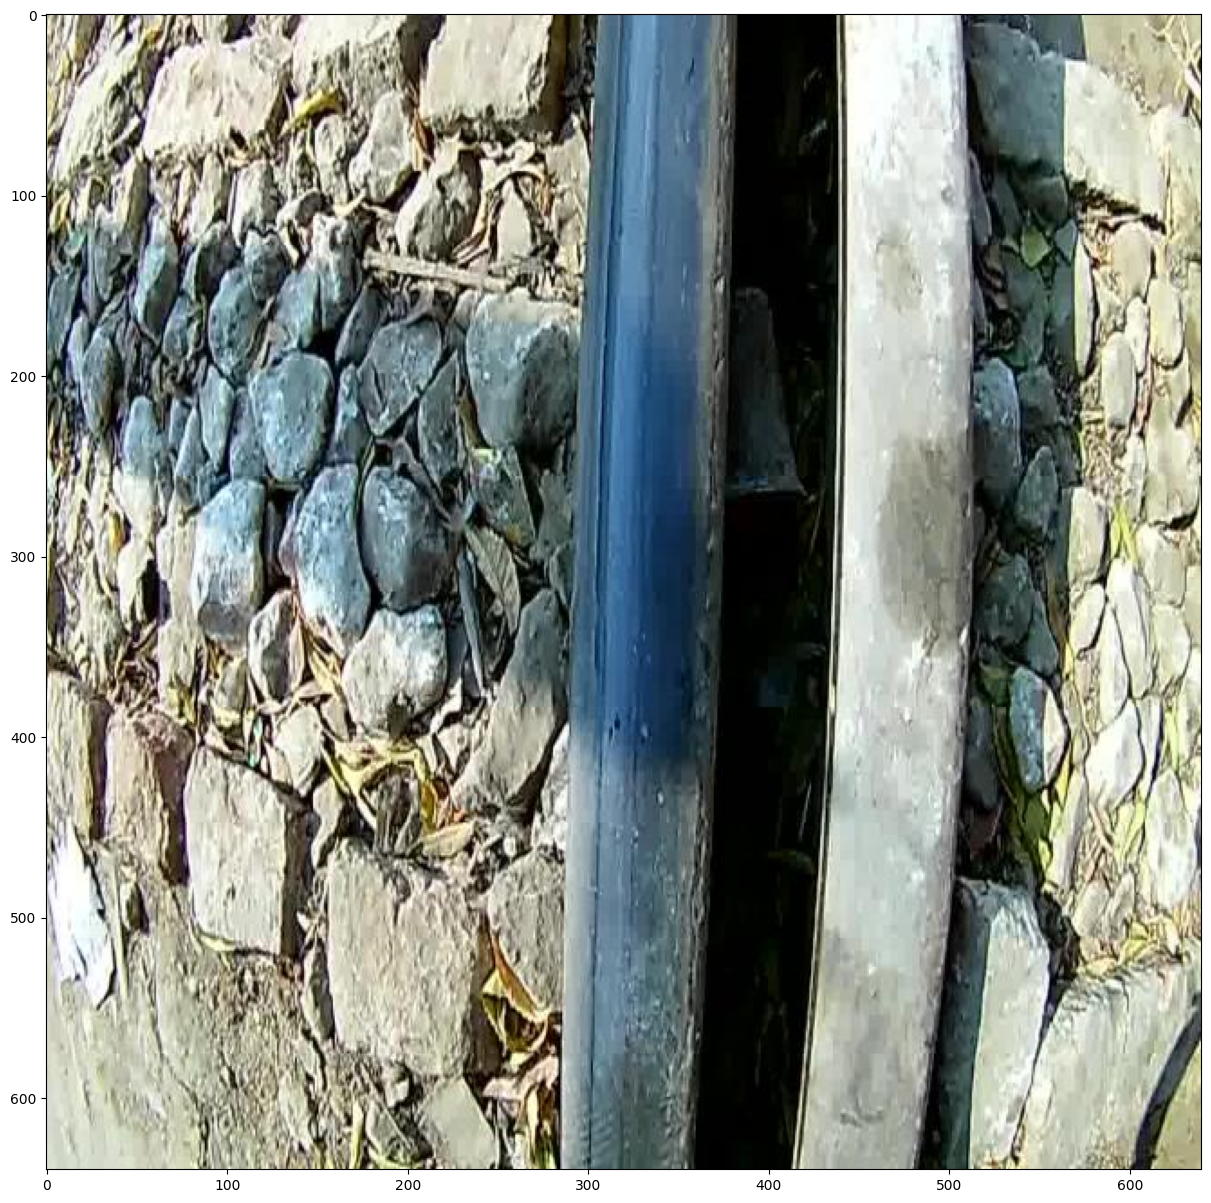

In [8]:
image_name = r"/content/Railway-Track-3/train/1-MOV_20201221091849_0245_JPEG.rf.c3df0144b0ee3e21e323f6f71c309d4a.jpg"

img = Image.open(image_name)
fig, ax = plt.subplots()
ax.imshow(img)
plt.show()

In [10]:
image_ids_annotations = defaultdict(list)

# Load annotations
path = r'/content/Railway-Track-3/train/_annotations.coco.json'
file = open(path)
anns = json.load(file)

# Add into datastructure
for ann in anns['annotations']:
    image_id = ann['image_id'] # Are integers
    image_ids_annotations[image_id].append(ann)

In [11]:
# Get mapping category_id to category name
catergory_id_to_name = dict()
for ann in anns['categories']:
    catergory_id_to_name[ann['id']] = ann['name']

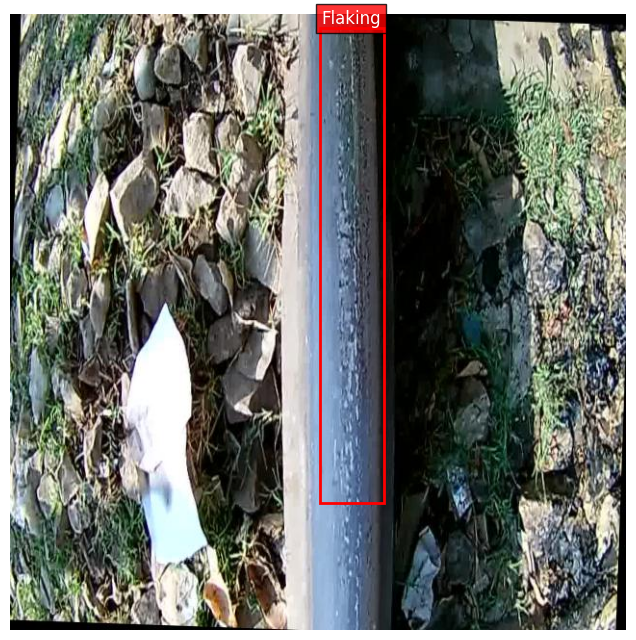

In [15]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

def load_coco_annotations(json_path):
    """Load and verify COCO format annotations"""
    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    # Create category mapping
    category_id_to_name = {
        cat['id']: cat['name']
        for cat in coco_data['categories']
    }

    # Create filename to image ID mapping
    filename_to_id = {
        img['file_name']: img['id']
        for img in coco_data['images']
    }

    # Create image ID to annotations mapping
    image_ids_annotations = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in image_ids_annotations:
            image_ids_annotations[img_id] = []
        image_ids_annotations[img_id].append(ann)

    logger.debug(f"Loaded {len(filename_to_id)} images")
    logger.debug(f"Loaded {len(image_ids_annotations)} image annotations")

    return category_id_to_name, image_ids_annotations, filename_to_id

def visualize_annotations(image_path, image_ids_annotations, category_id_to_name, filename_to_id):
    """Visualize image with correct bounding boxes"""
    try:
        filename = os.path.basename(image_path)

        # Get correct image ID from filename mapping
        if filename not in filename_to_id:
            logger.error(f"Image {filename} not found in annotations")
            return

        image_id = filename_to_id[filename]
        logger.debug(f"Processing image ID: {image_id}")

        img = Image.open(image_path)
        fig, ax = plt.subplots(figsize=(12, 8))

        if image_id in image_ids_annotations:
            annotations = image_ids_annotations[image_id]
            logger.debug(f"Found {len(annotations)} annotations for image")

            for ann in annotations:
                bbox = ann['bbox']
                category_name = category_id_to_name[ann['category_id']]

                x, y, w, h = [float(coord) for coord in bbox]
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2,
                    edgecolor='red',
                    facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(
                    x+1, y-5,
                    category_name,
                    fontsize=12,
                    color='white',
                    bbox=dict(facecolor='red', alpha=0.8)
                )
        else:
            logger.warning(f"No annotations found for image ID {image_id}")

        ax.axis('off')
        ax.imshow(img)
        plt.show()

    except Exception as e:
        logger.error(f"Error visualizing image: {e}")

if __name__ == "__main__":
    json_path = r'/content/Railway-Track-3/train/_annotations.coco.json'
    image_path = r"/content/Railway-Track-3/train/1-MOV_20201221091849_5178_JPEG.rf.3a30ebc0077153c14f244924c7d83c33.jpg"

    category_id_to_name, image_ids_annotations, filename_to_id = load_coco_annotations(json_path)
    visualize_annotations(image_path, image_ids_annotations, category_id_to_name, filename_to_id)

In [16]:
import os
import json
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [17]:
import os
import json
from collections import defaultdict

base_dir = r'/content/Railway-Track-3'

annotations = defaultdict(dict)
for split in ['test', 'train', 'valid']:
    with open(os.path.join(base_dir, split, '_annotations.coco.json'), 'r') as f:
        annotations[split] = json.load(f)

In [18]:
import os
import json
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from tqdm import tqdm

In [61]:
class RailwayTrackDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split

        # Load annotations
        ann_file = os.path.join(root_dir, split, '_annotations.coco.json')
        with open(ann_file, 'r') as f:
            self.coco = json.load(f)

        # Create category mapping
        self.categories = {cat['id']: cat['name'] for cat in self.coco['categories']}

        # Create image to annotations mapping
        self.img_to_anns = self._load_annotations()

        # Create image list for easy indexing
        self.image_ids = [img['id'] for img in self.coco['images']]

        # Setup transforms
        self.transform = transform or T.Compose([
            T.Resize((640, 640)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _load_annotations(self):
        img_to_anns = {}
        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in img_to_anns:
                img_to_anns[img_id] = []
            img_to_anns[img_id].append(ann)
        return img_to_anns

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
      img_id = self.image_ids[idx]
      img_info = next(img for img in self.coco['images'] if img['id'] == img_id)

      img_path = os.path.join(self.root_dir, self.split, img_info['file_name'])
      image = Image.open(img_path).convert('RGB')

      boxes, labels = [], []
      for ann in self.img_to_anns.get(img_id, []):
          x, y, w, h = ann['bbox']
          boxes.append([x, y, x + w, y + h])
          labels.append(ann['category_id'])

      if boxes:  # Ensure there are bounding boxes
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          area = torch.as_tensor(
              [(box[2] - box[0]) * (box[3] - box[1]) for box in boxes], dtype=torch.float32
          )
      else:  # Handle cases with no bounding boxes
          boxes = torch.zeros((0, 4), dtype=torch.float32)
          area = torch.zeros((0,), dtype=torch.float32)

      labels = torch.as_tensor(labels, dtype=torch.int64)
      iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

      target = {
          'boxes': boxes,
          'labels': labels,
          'image_id': torch.tensor([img_id]),
          'area': area,
          'iscrowd': iscrowd,
      }

      if self.transform:
          image = self.transform(image)

      return image, target

def collate_fn(batch):
    return tuple(zip(*batch))


In [62]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [75]:
root_dir = r"/content/Railway-Track-3"

train_dataset = RailwayTrackDataset(root_dir=root_dir, split="train")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1, collate_fn=collate_fn)

test_dataset = RailwayTrackDataset(root_dir=root_dir, split="test")
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=1, collate_fn=collate_fn)

valid_dataset = RailwayTrackDataset(root_dir=root_dir, split="valid")
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=1, collate_fn=collate_fn)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size : {len(test_dataset)}")


num_classes = len(train_dataset.categories)
print(f"Number of classes: {num_classes}")
print(f"Train Categories: {train_dataset.categories}")
print(f"Test Categories: {test_dataset.categories}")
print(f"Valid Categories: {valid_dataset.categories}")


Training dataset size: 862
Validation dataset size: 123
Test dataset size : 61
Number of classes: 4
Train Categories: {0: 'Cracks', 1: 'Flaking', 2: 'Shelling', 3: 'Squats'}
Test Categories: {0: 'Cracks', 1: 'Flaking', 2: 'Shelling', 3: 'Squats'}
Valid Categories: {0: 'Cracks', 1: 'Flaking', 2: 'Shelling', 3: 'Squats'}


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Epoch 1 - Training: 100%|██████████| 216/216 [02:47<00:00,  1.29it/s]


Epoch 1 - Training Loss: 0.2644


Epoch 1 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.78it/s]


Epoch 1 - Validation Metrics:
  - mAP: 0.0106
  - Precision: 0.0425
  - Recall: 0.0027
Epoch 1 - Validation Results:
  - mAP: 0.0106
  - Precision: 0.0425
  - Recall: 0.0027


Epoch 2 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 2 - Training Loss: 0.2125


Epoch 2 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Epoch 2 - Validation Metrics:
  - mAP: 0.0690
  - Precision: 0.2224
  - Recall: 0.0166
Epoch 2 - Validation Results:
  - mAP: 0.0690
  - Precision: 0.2224
  - Recall: 0.0166


Epoch 3 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 3 - Training Loss: 0.1904


Epoch 3 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 3 - Validation Metrics:
  - mAP: 0.1276
  - Precision: 0.3724
  - Recall: 0.0532
Epoch 3 - Validation Results:
  - mAP: 0.1276
  - Precision: 0.3724
  - Recall: 0.0532


Epoch 4 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 4 - Training Loss: 0.1619


Epoch 4 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Epoch 4 - Validation Metrics:
  - mAP: 0.1667
  - Precision: 0.4287
  - Recall: 0.0915
Epoch 4 - Validation Results:
  - mAP: 0.1667
  - Precision: 0.4287
  - Recall: 0.0915


Epoch 5 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 5 - Training Loss: 0.1548


Epoch 5 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Epoch 5 - Validation Metrics:
  - mAP: 0.1687
  - Precision: 0.4465
  - Recall: 0.0872
Epoch 5 - Validation Results:
  - mAP: 0.1687
  - Precision: 0.4465
  - Recall: 0.0872


Epoch 6 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 6 - Training Loss: 0.1510


Epoch 6 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Epoch 6 - Validation Metrics:
  - mAP: 0.1681
  - Precision: 0.4414
  - Recall: 0.0743
Epoch 6 - Validation Results:
  - mAP: 0.1681
  - Precision: 0.4414
  - Recall: 0.0743


Epoch 7 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 7 - Training Loss: 0.1471


Epoch 7 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Epoch 7 - Validation Metrics:
  - mAP: 0.1795
  - Precision: 0.4574
  - Recall: 0.0855
Epoch 7 - Validation Results:
  - mAP: 0.1795
  - Precision: 0.4574
  - Recall: 0.0855


Epoch 8 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 8 - Training Loss: 0.1454


Epoch 8 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Epoch 8 - Validation Metrics:
  - mAP: 0.1807
  - Precision: 0.4604
  - Recall: 0.0918
Epoch 8 - Validation Results:
  - mAP: 0.1807
  - Precision: 0.4604
  - Recall: 0.0918


Epoch 9 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 9 - Training Loss: 0.1455


Epoch 9 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Epoch 9 - Validation Metrics:
  - mAP: 0.1803
  - Precision: 0.4719
  - Recall: 0.0884
Epoch 9 - Validation Results:
  - mAP: 0.1803
  - Precision: 0.4719
  - Recall: 0.0884


Epoch 10 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 10 - Training Loss: 0.1451


Epoch 10 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 10 - Validation Metrics:
  - mAP: 0.1778
  - Precision: 0.4675
  - Recall: 0.0880
Epoch 10 - Validation Results:
  - mAP: 0.1778
  - Precision: 0.4675
  - Recall: 0.0880


Epoch 11 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 11 - Training Loss: 0.1455


Epoch 11 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 11 - Validation Metrics:
  - mAP: 0.1781
  - Precision: 0.4703
  - Recall: 0.0873
Epoch 11 - Validation Results:
  - mAP: 0.1781
  - Precision: 0.4703
  - Recall: 0.0873


Epoch 12 - Training: 100%|██████████| 216/216 [02:46<00:00,  1.30it/s]


Epoch 12 - Training Loss: 0.1449


Epoch 12 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 12 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863
Epoch 12 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863


Epoch 13 - Training: 100%|██████████| 216/216 [02:46<00:00,  1.30it/s]


Epoch 13 - Training Loss: 0.1448


Epoch 13 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Epoch 13 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863
Epoch 13 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863


Epoch 14 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 14 - Training Loss: 0.1442


Epoch 14 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Epoch 14 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863
Epoch 14 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863


Epoch 15 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 15 - Training Loss: 0.1452


Epoch 15 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.72it/s]


Epoch 15 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863
Epoch 15 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863
Model saved at epoch 15.


Epoch 16 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 16 - Training Loss: 0.1449


Epoch 16 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 16 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863
Epoch 16 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863


Epoch 17 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 17 - Training Loss: 0.1441


Epoch 17 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Epoch 17 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863
Epoch 17 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4662
  - Recall: 0.0863


Epoch 18 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 18 - Training Loss: 0.1451


Epoch 18 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Epoch 18 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 18 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 19 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 19 - Training Loss: 0.1446


Epoch 19 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 19 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 19 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 20 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 20 - Training Loss: 0.1440


Epoch 20 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.78it/s]


Epoch 20 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 20 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 21 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 21 - Training Loss: 0.1451


Epoch 21 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Epoch 21 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 21 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 22 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 22 - Training Loss: 0.1440


Epoch 22 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 22 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 22 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 23 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 23 - Training Loss: 0.1446


Epoch 23 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 23 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 23 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 24 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 24 - Training Loss: 0.1446


Epoch 24 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 24 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 24 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 25 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 25 - Training Loss: 0.1444


Epoch 25 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 25 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 25 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 26 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 26 - Training Loss: 0.1443


Epoch 26 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 26 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 26 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 27 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 27 - Training Loss: 0.1447


Epoch 27 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.78it/s]


Epoch 27 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 27 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 28 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 28 - Training Loss: 0.1447


Epoch 28 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Epoch 28 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 28 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 29 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 29 - Training Loss: 0.1444


Epoch 29 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Epoch 29 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 29 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863


Epoch 30 - Training: 100%|██████████| 216/216 [02:45<00:00,  1.30it/s]


Epoch 30 - Training Loss: 0.1450


Epoch 30 - Evaluation: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 30 - Validation Metrics:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Epoch 30 - Validation Results:
  - mAP: 0.1769
  - Precision: 0.4661
  - Recall: 0.0863
Model saved at epoch 30.


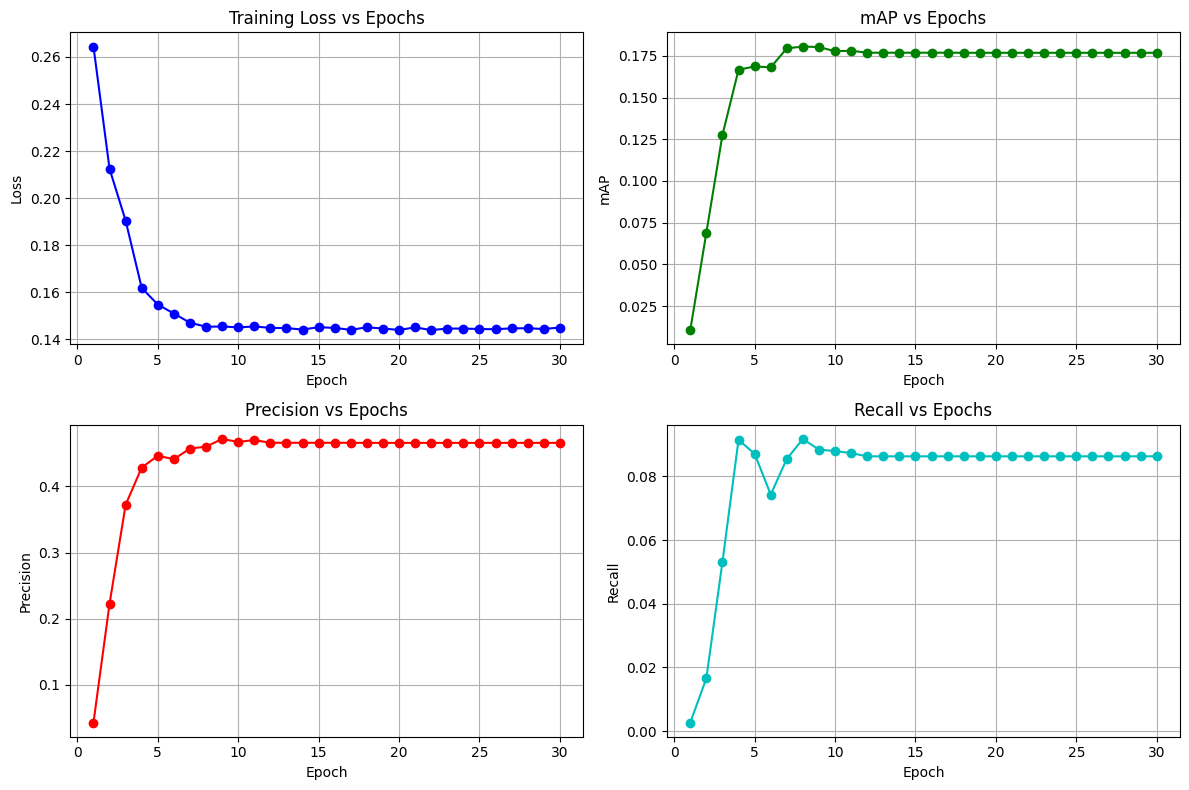

Training completed.


In [76]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Initialize the MeanAveragePrecision metric
metric = MeanAveragePrecision()

# Lists to store values for plotting
train_losses = []
val_maps = []
val_precisions = []
val_recalls = []

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    for images, targets in tqdm(data_loader, desc=f"Epoch {epoch} - Training"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(data_loader)  # Average loss for the epoch

@torch.no_grad()  # Disable gradient computation during evaluation
def evaluate(model, data_loader, device, epoch):
    model.eval()  # Set the model to evaluation mode
    metric.reset()  # Reset the metric calculator for the validation set

    for images, targets in tqdm(data_loader, desc=f"Epoch {epoch} - Evaluation"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        preds = model(images)  # Get predictions
        metric.update(preds, targets)  # Update the metric calculator

    epoch_metrics = metric.compute()  # Compute the metrics
    print(f"Epoch {epoch} - Validation Metrics:")
    print(f"  - mAP: {epoch_metrics['map']:.4f}")
    print(f"  - Precision: {epoch_metrics['map_50']:.4f}")  # Precision @ IoU=0.50
    print(f"  - Recall: {epoch_metrics['map_75']:.4f}")     # Recall @ IoU=0.75
    return epoch_metrics

# --- Training Loop ---
model = get_model(num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 30

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    print(f"Epoch {epoch} - Training Loss: {train_loss:.4f}")

    val_metrics = evaluate(model, valid_loader, device, epoch)

    # Extract additional metrics
    val_map = val_metrics['map']
    val_precision = val_metrics['map_50']
    val_recall = val_metrics['map_75']

    print(f"Epoch {epoch} - Validation Results:")
    print(f"  - mAP: {val_map:.4f}")
    print(f"  - Precision: {val_precision:.4f}")
    print(f"  - Recall: {val_recall:.4f}")

    # Save the model every 15th epoch
    if epoch % 15 == 0:
        torch.save(model.state_dict(), f"faster_rcnn_epoch_{epoch}.pth")
        print(f"Model saved at epoch {epoch}.")

    # Store metrics for plotting
    train_losses.append(train_loss)
    val_maps.append(val_map)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    lr_scheduler.step()

# --- Plotting Results ---
epochs_range = range(1, num_epochs + 1)

# Plot Loss Curve
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color='b', linestyle='-', marker='o')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot mAP Curve
plt.subplot(2, 2, 2)
plt.plot(epochs_range, val_maps, label='mAP', color='g', linestyle='-', marker='o')
plt.title('mAP vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.grid(True)

# Plot Precision Curve
plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_precisions, label='Precision (IoU=0.50)', color='r', linestyle='-', marker='o')
plt.title('Precision vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.grid(True)

# Plot Recall Curve
plt.subplot(2, 2, 4)
plt.plot(epochs_range, val_recalls, label='Recall (IoU=0.75)', color='c', linestyle='-', marker='o')
plt.title('Recall vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)

# Show all plots
plt.tight_layout()
plt.show()

print("Training completed.")
